In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data_syscall = pd.read_csv('/content/drive/MyDrive/SWE-Masters/Statistical Machine Learning/MalDroid2020/feature_vectors_syscalls_frequency_5_Cat.csv')
data_all = pd.read_csv('/content/drive/MyDrive/SWE-Masters/Statistical Machine Learning/MalDroid2020/feature_vectors_syscallsbinders_frequency_5_Cat.csv')
# Understand how the data is structured
print(data_syscall.head())
print(data_all.head())


# Print out the counts
label_counts = data_syscall['Class'].value_counts() # Label counts
print("Label Counts:\n", label_counts)

# Output the sizes of the split datasets
print("Syscall set size:", data_syscall.shape)
print("Syscallbinders set size:", data_all.shape)


   __arm_nr_cacheflush  __arm_nr_set_tls  _llseek  _newselect  accept  access  \
0                  0.0              14.0      6.0         0.0     0.0    11.0   
1               1590.0              42.0      6.0         0.0     0.0    47.0   
2                  0.0              23.0      6.0         0.0     0.0    40.0   
3                  0.0              27.0      6.0         0.0     0.0    60.0   
4                  0.0              18.0      6.0         0.0     0.0    26.0   

   bind     brk  capset  chdir  ...  ugetrlimit  umask  uname  unlink  utimes  \
0   3.0    21.0     1.0    0.0  ...         0.0    0.0    1.0     0.0     0.0   
1   2.0  1430.0     1.0    0.0  ...         2.0    0.0    1.0     4.0     0.0   
2   9.0    89.0     1.0    0.0  ...         0.0    0.0    1.0     2.0     0.0   
3   1.0   242.0     1.0    0.0  ...         0.0    0.0    1.0     2.0     0.0   
4   5.0    59.0     1.0    0.0  ...         0.0    0.0    1.0     0.0     0.0   

   vfork  wait4   write  w

Model: syscallsbinders
Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.94      0.91       262
           2       0.98      0.89      0.93       424
           3       0.97      0.99      0.98       786
           4       0.94      0.92      0.93       500
           5       0.89      0.94      0.91       348

    accuracy                           0.94      2320
   macro avg       0.93      0.93      0.93      2320
weighted avg       0.94      0.94      0.94      2320

Accuracy: 0.9431034482758621


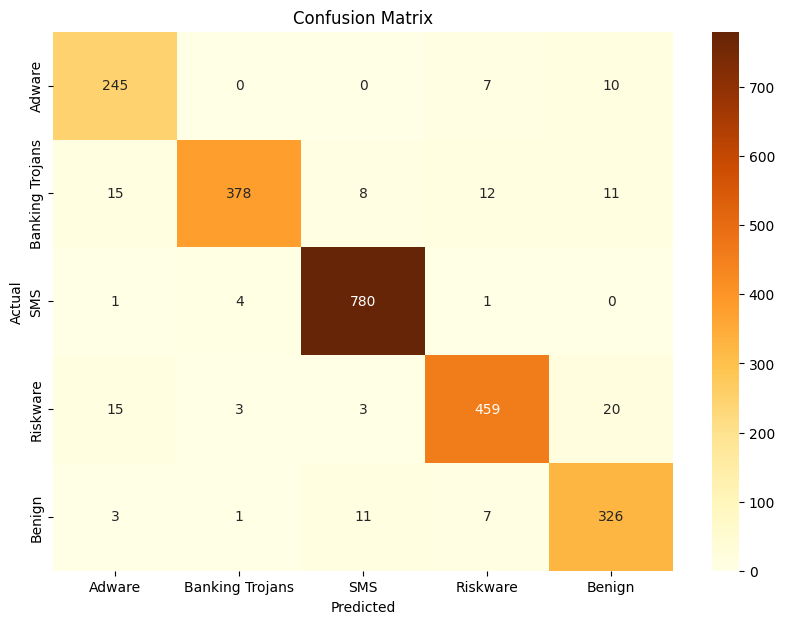

In [18]:
from math import inf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

malware_family_mapping = {
    1: 'Adware',
    2: 'Banking Trojans',
    3: 'SMS',
    4: 'Riskware',
    5: 'Benign'
}

# Build a RFC for both CSVs and determine which on initially is best to use
data_files = {"syscalls":data_syscall, "syscallsbinders":data_all}
best_file = ""
best_acc = 0
cr = None # Classification report
for k,v in data_files.items():
  # Last column is 'label'
  X = v.drop('Class', axis=1)  # Features
  y = v['Class']               # Labels
  # We'll use 80% of the data for training and 20% for testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize the Random Forest Classifier
  model = RandomForestClassifier(n_estimators=100, random_state=42)  # tune these parameters

  # Train the model
  model.fit(X_train, y_train)

  # Make predictions
  predictions = model.predict(X_test)
  # Evaluate the model
  acc = accuracy_score(y_test, predictions)
  if acc > best_acc:
    best_acc = acc
    best_file = k
    cr = classification_report(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)

# Print best results and Confusion Matrix
print(f"Model: {best_file}")
print("Classification Report:\n", cr)
print("Accuracy:", best_acc)
# Define the class labels
class_labels = malware_family_mapping.values()
plt.figure(figsize=(10, 7))
# heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrBr', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# Dictionary that collects all classification reports
clReports = {}
clReports['RFC_allfeatures'] = cr

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import randint as sp_randint
import numpy as np

# Using the syscallsbinders dataset for rest of project models
X = data_all.drop('Class', axis=1)
y = data_all['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = {}
n_classes = np.unique(y_train).size
total_observations = len(y_train)

for cls in np.unique(y_train):
    class_weights[cls] = total_observations / (n_classes * np.bincount(y_train)[cls])

# Parameter grid to sample from during fitting
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 20),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'max_features': sp_randint(1, 125),
    'bootstrap': [True, False],
}
# Initialize the RandomForestClassifier & CV
rfc = RandomForestClassifier(random_state=42, class_weight=class_weights)
random_search = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=150, cv=5,
                                   scoring='accuracy', random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV and find best
random_search.fit(X_train, y_train)
best_rfc = random_search.best_estimator_

# Predict on the test set using the best model
predictions = best_rfc.predict(X_test)
cr_rfctuned = classification_report(y_test, predictions)
# Print the best parameters and the evaluation
print("Best Parameters:", random_search.best_params_)
print("Classification Report:\n", cr_rfctuned)
print("Accuracy:", accuracy_score(y_test, predictions))
#Add cr to reports dict
clReports['RFC_allfeatures_tuned'] = cr_rfctuned

Best Parameters: {'bootstrap': False, 'max_depth': 19, 'max_features': 62, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 367}
Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.95      0.91       262
           2       0.97      0.89      0.93       424
           3       0.98      0.99      0.98       786
           4       0.96      0.93      0.94       500
           5       0.90      0.95      0.92       348

    accuracy                           0.95      2320
   macro avg       0.94      0.94      0.94      2320
weighted avg       0.95      0.95      0.95      2320

Accuracy: 0.9478448275862069


From this point forward, we will reduce the feature set of the data to avoid bottle necks. The model above took 15 minutes to train with a RFC. Trying to train Logistic regression and SVM models with all the features will be too computationally expensive. In feature selection, we aim to select the features which are highly dependent on the response. We will use Recursive Feture Elimination (Logisitc Regression) & Chi-Square scores for the selection. High Chi-Square value indicates that the hypothesis of independence is incorrect. In simple words, higher the Chi-Square value the feature is more dependent on the response and it can be selected for model training.


In [27]:
import pandas as pd
binder_syscalls = pd.read_csv('/content/drive/MyDrive/SWE-Masters/Statistical Machine Learning/MalDroid2020/feature_vectors_syscallsbinders_frequency_5_Cat.csv')

#re-assign to avoid a huge code re-factor LOL
df2 = binder_syscalls
# Understand how the data is structured
binder_syscalls.describe()


,ACCESS_PERSONAL_INFO___,ALTER_PHONE_STATE___,ANTI_DEBUG_____,CREATE_FOLDER_____,CREATE_PROCESS`_____,CREATE_THREAD_____,DEVICE_ACCESS_____,EXECUTE_____,FS_ACCESS____,FS_ACCESS()____,...,utimes,vfork,vibrate,vibratePattern,wait4,watchRotation,windowGainedFocus,write,writev,Class
count,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000,11598.00000,11598.000000,11598.000000,...,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000,11598.000000,1.159800e+04,11598.000000
mean,57.435334,0.001207,0.044577,5.781342,0.983877,29.770391,29.641749,2.25125,73.661493,6.688395,...,0.093292,2.232454,0.001811,0.000690,6.453958,0.000690,1.647870,1071.197362,1.039598e+03,3.131919
std,444.149233,0.055703,1.104287,10.380946,4.061886,32.170379,267.652850,9.86903,219.079872,20.050449,...,1.808335,15.691146,0.070084,0.029357,164.278529,0.026256,9.927242,6151.477714,1.712849e+04,1.197716
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000,10.000000,2.000000,0.00000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.000000,1.200000e+01,2.000000
50%,2.000000,0.000000,0.000000,3.000000,0.000000,17.000000,3.000000,0.00000,20.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,256.000000,4.400000e+01,3.000000
75%,8.000000,0.000000,0.000000,6.000000,0.000000,39.000000,21.000000,0.00000,52.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1142.750000,1.440000e+02,4.000000
max,7647.000000,5.000000,91.000000,700.000000,140.000000,1332.000000,26631.000000,399.00000,8380.000000,1192.000000,...,113.000000,117.000000,6.000000,2.000000,17431.000000,1.000000,1042.000000,490069.000000,1.301356e+06,5.000000


First we will apply L2 normalization to the data set, and then perform Chi-sqaure test

In [29]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

# Create a normalizer object with L2 normalization
normalizer = Normalizer(norm='l2')

# Now, X_normalized contains the L2 normalized version of the input features

X = df2.drop('Class', axis=1)  # Features
y = df2['Class']  # Labels

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Fit the scaler on the training data and transform the testing data
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Convert back to pandas data frame
X_train = pd.DataFrame(X_train_norm, columns=X.columns, index=X[:len(X_train)].index)
X_test = pd.DataFrame(X_test_norm, columns=X.columns, index=X[:len(X_test)].index)

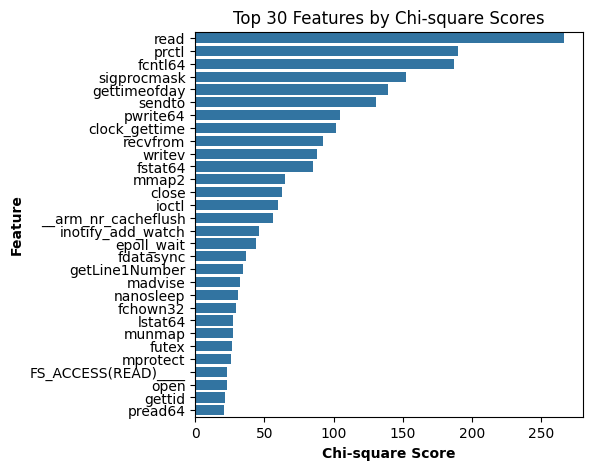

In [30]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Chi-squared test
chi2_selector = SelectKBest(chi2, k='all')  # Select 30 best features
chi2_selector.fit(X_train, y_train)
selected_feature_names = chi2_selector.get_feature_names_out()
scores = chi2_selector.scores_
p_values = chi2_selector.pvalues_

# Create DataFrame with scores and feature names
features_scores = pd.DataFrame({'Feature': selected_feature_names, 'Chi2Score': scores, 'P-Value': p_values})
# Sort the DataFrame by 'Chi2Score' in descending order
features_scores_sorted = features_scores.sort_values(by='Chi2Score', ascending=False)
# print(features_scores_sorted)
# Plot
plt.figure(figsize=(5, 5))
sns.barplot(data=features_scores_sorted[:30], x='Chi2Score', y='Feature')  # Display top 30 features
plt.title('Top 30 Features by Chi-square Scores')
plt.xlabel('Chi-square Score', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.show()


In [32]:
# Create a LaTex table for report
# Assuming 'features_scores_sorted' is your DataFrame with the necessary columns
features_scores_sorted['Abbreviation'] = ['F' + str(i) for i in range(1, len(features_scores_sorted) + 1)]

# Select the top 30 features
top_30_features = features_scores_sorted.head(30)

# Export the table to LaTeX
with open('chi_square_table.tex', 'w') as tf:
    tf.write(top_30_features.to_latex(index=False, caption='Top 30 features with highest chi-square score.', label='tab:chi_square_scores'))


# Optional visualization for development

# from IPython.display import display
# from pandas.io.formats.style import Styler


# def style_specific_cell(x):
#     color = 'background-color: red'
#     df1 = pd.DataFrame('', index=x.index, columns=x.columns)
#     # Suppose you want to highlight the max value in the 'Chi2Score' column
#     max_value_index = x['Chi2Score'].idxmax()
#     return df1

# styled_table = top_30_features.style.apply(style_specific_cell, axis=None)
# styled_table.set_caption('Top 30 features with highest chi-square score.')
# display(styled_table)

In [ ]:
# Top 30 feature names as a list
top_30_feature_names = top_30_features['Feature'].tolist()

# Filter X_train to include only the top 30 features
X_train_top_30 = X_train[top_30_feature_names]
# Create new dataframe
X_train_top_30.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
red_fsyscalls_train = pd.concat([X_train_top_30, y_train], axis=1)

red_fsyscalls_train.describe()

In [34]:
# Create a new test dataframe
X_test_top_30 = X_test[top_30_feature_names]
X_test_top_30.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
red_fsyscalls_test = pd.concat([X_test_top_30, y_test], axis=1)

In [36]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# Get training/testing features and labels from the reduced dataset
X_train = red_fsyscalls_train.drop('Class', axis=1)
y_train = red_fsyscalls_train['Class']
X_test = red_fsyscalls_test.drop('Class', axis=1)
y_test = red_fsyscalls_test['Class']
# Create a pipeline that standardizes the data then trains an SVM
pipeline = make_pipeline(StandardScaler(), SVC(gamma='scale'))

# Train the SVM on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the SVM
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))


Test set Accuracy: 0.8094827586206896
              precision    recall  f1-score   support

           1       0.71      0.56      0.63       262
           2       0.84      0.76      0.80       424
           3       0.85      0.96      0.90       786
           4       0.80      0.82      0.81       500
           5       0.76      0.71      0.73       348

    accuracy                           0.81      2320
   macro avg       0.79      0.76      0.77      2320
weighted avg       0.81      0.81      0.80      2320



In [ ]:
# Run a study to find the best C value for the SVC model
# using 5-fold cross-validation
!pip install --quiet optuna
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
# Reduce verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    c = trial.suggest_float('C', 1e-4, 1e4, log=True)
    svc = SVC(C=c)
    score = cross_val_score(svc, X_train, y_train, n_jobs=-1, cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_C = study.best_params['C']
print(f"The best value for C is: {best_C}")


In [40]:
# Retrain with optimal C
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
# old best C from ALL features
# best_c = 1513.5661896082163

# Tuned C Hyperparameter
svc = SVC(C=best_C, gamma='scale')

# Make Pipeline
pipeline = make_pipeline(StandardScaler(), svc)
pipeline.fit(X_train, y_train)

# Test
y_pred = pipeline.predict(X_test)

# Evaluate model
cr_svctuned = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
clReports['SVC_top30_tuned'] = cr_svctuned

Test set accuracy: 0.8896551724137931
              precision    recall  f1-score   support

           1       0.77      0.82      0.79       262
           2       0.88      0.87      0.87       424
           3       0.97      0.99      0.98       786
           4       0.89      0.87      0.88       500
           5       0.82      0.78      0.80       348

    accuracy                           0.89      2320
   macro avg       0.86      0.86      0.86      2320
weighted avg       0.89      0.89      0.89      2320



In [41]:
# Multinomial Logistic Regression
# Using X_train & X_test filtered on the top 30 features based on Chi-Square scores
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class='multinomial',
                       solver='saga',
                       C=1.0,
                       max_iter=1000)
    )

# Train the logistic regression model on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)
cr_logreg = classification_report(y_test, y_pred)
# Evaluate the model
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print(cr_logreg)
clReports["LogReg_top30"] = cr_logreg


Accuracy on test data: 0.6801724137931034
              precision    recall  f1-score   support

           1       0.62      0.32      0.42       262
           2       0.67      0.56      0.61       424
           3       0.76      0.91      0.83       786
           4       0.64      0.66      0.65       500
           5       0.57      0.62      0.59       348

    accuracy                           0.68      2320
   macro avg       0.65      0.61      0.62      2320
weighted avg       0.67      0.68      0.67      2320



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The best 'C' value is: 600


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal number of features: 27
Selected features: Index(['read', 'prctl', 'fcntl64', 'sigprocmask', 'sendto', 'pwrite64',
       'clock_gettime', 'recvfrom', 'writev', 'fstat64', 'mmap2', 'close',
       'ioctl', '__arm_nr_cacheflush', 'inotify_add_watch', 'epoll_wait',
       'fdatasync', 'getLine1Number', 'madvise', 'nanosleep', 'fchown32',
       'lstat64', 'munmap', 'mprotect', 'FS_ACCESS(READ)____', 'open',
       'pread64'],
      dtype='object')
Test set accuracy: 0.6918103448275862


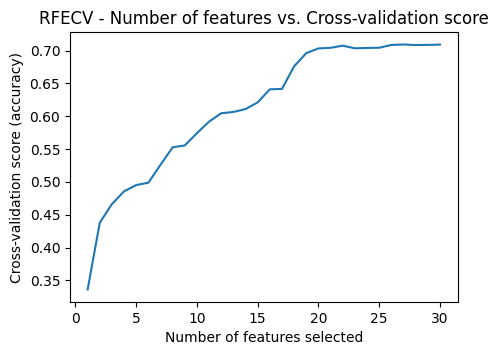

In [42]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import warnings

# Create training and testing datasets
X_train = red_fsyscalls_train.drop('Class', axis=1)
y_train = red_fsyscalls_train['Class']

# Phase 1: Optimize the 'C' hyperparameter using GridSearchCV

# Create a pipeline with just a StandardScaler and LogisticRegression for the grid search
C_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=5000))
])

# Parameter grid focusing on the 'C' hyperparameter, randomized search may take too long
C_param_grid = {
    'logreg__C': [0.1, 1, 10, 100, 200, 300, 400, 600]
}

# Initialize GridSearchCV for finding the best 'C'
C_grid_search = GridSearchCV(C_pipeline, C_param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)

# Grid search
C_grid_search.fit(X_train, y_train)

# best 'C'
best_C = C_grid_search.best_params_['logreg__C']
print(f"The best 'C' value is: {best_C}")

# Phase 2: Perform RFECV with the optimized 'C' value

# logistic regression model using the best 'C'
logreg = LogisticRegression(multi_class='multinomial', solver='saga', C=best_C, max_iter=5000)

# Initialize RFECV with the optimized model
min_features_to_select = 1
rfecv = RFECV(estimator=logreg, step=1,
              cv=StratifiedKFold(5),
              min_features_to_select=min_features_to_select,
              scoring='accuracy', n_jobs=-1)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale data to improve convergence
    ('rfecv', rfecv)
])
# Fit RFECV
pipeline.fit(X_train, y_train)

# RFECV results
print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {X_train.columns[rfecv.support_]}")

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))
cr_logreg_RFE = classification_report(y_test, y_pred)
# Add to clReports
clReports['LogReg_RFE_tuned'] = cr_logreg_RFE

# Plotting the number of features vs. cross-validation scores
cv_results = rfecv.cv_results_['mean_test_score']
n_scores = len(cv_results)
features_range = range(min_features_to_select, n_scores + min_features_to_select)
plt.figure(figsize=(5, 3.5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(features_range, cv_results)
plt.title('RFECV - Number of features vs. Cross-validation score')
plt.show()

In [61]:
print(cr_logreg_RFE)

              precision    recall  f1-score   support

           1       0.56      0.29      0.39       262
           2       0.67      0.62      0.65       424
           3       0.77      0.91      0.84       786
           4       0.67      0.65      0.66       500
           5       0.59      0.64      0.61       348

    accuracy                           0.69      2320
   macro avg       0.65      0.62      0.63      2320
weighted avg       0.68      0.69      0.68      2320



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best parameters found: {'base_estimator__max_depth': 15, 'learning_rate': 0.78}
Test set accuracy: 0.9150862068965517


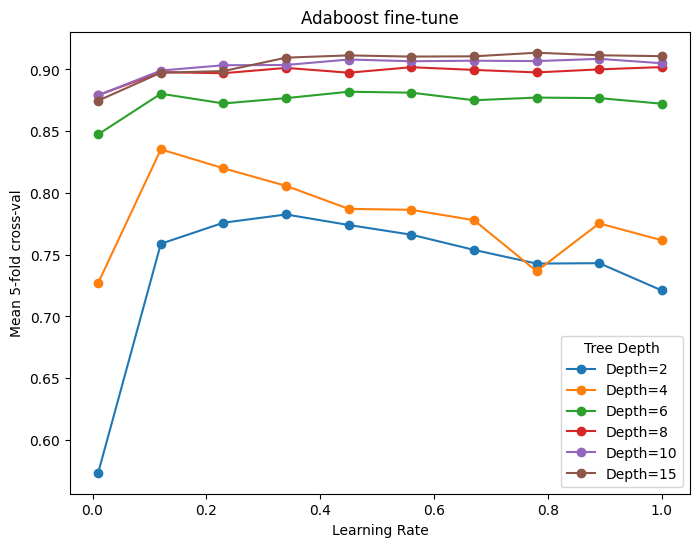

In [43]:
# Tuning just adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Train & test splits based on filtered set
X_train = red_fsyscalls_train.drop('Class', axis=1)
y_train = red_fsyscalls_train['Class']
X_test = red_fsyscalls_test.drop('Class', axis=1)
y_test = red_fsyscalls_test['Class']

# Decision Tree base classifier
base_clf = DecisionTreeClassifier(random_state=42)

# Initialize AdaBoost with the base classifier
ada_boost = AdaBoostClassifier(base_estimator=base_clf, random_state=42)

# Define the parameter grid
param_grid = {
    'base_estimator__max_depth': [2, 4, 6, 8, 10, 15],  # Depths of the decision tree
    'learning_rate': np.linspace(0.01, 1, 10)     # Learning rates
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=ada_boost, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Analyze grid
print("Best parameters found:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the model on the test data
y_pred = best_model.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))
cr_adaboost_tuned = classification_report(y_test, y_pred)
clReports['Adaboost_top30_tuned'] = cr_adaboost_tuned

# Mean test scores
mean_scores = grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['base_estimator__max_depth']), len(param_grid['learning_rate']))

# Plot CV scores vs hyper-parameters
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, depth in enumerate(param_grid['base_estimator__max_depth']):
    ax.plot(param_grid['learning_rate'], mean_scores[idx, :], '-o', label=f'Depth={depth}')

ax.set_title('Adaboost fine-tune')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean 5-fold cross-val')
ax.legend(title='Tree Depth')
plt.show()



Processing AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Processing Bagging...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best AdaBoost Test Accuracy: 0.9155172413793103
Best Bagging Test Accuracy: 0.8922413793103449


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


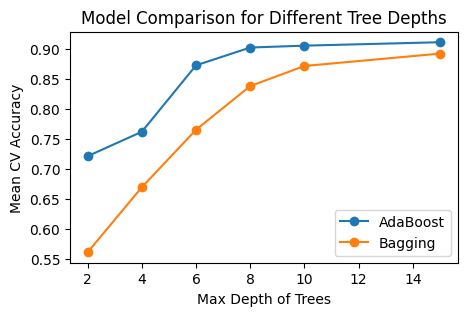

In [59]:
# Compare Adaboost and Bagging model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Train & test splits based on filtered set
X_train = red_fsyscalls_train.drop('Class', axis=1)
y_train = red_fsyscalls_train['Class']
X_test = red_fsyscalls_test.drop('Class', axis=1)
y_test = red_fsyscalls_test['Class']

# Base classifier
base_clf = DecisionTreeClassifier(random_state=42)

# Ensemble models
models = {
    'AdaBoost': AdaBoostClassifier(base_estimator=base_clf, random_state=42),
    'Bagging': BaggingClassifier(base_estimator=base_clf, random_state=42, n_estimators=100)
}

# Shared parameter grid for both models (focusing on Decision Tree depths)
param_grid = {
    'base_estimator__max_depth': [2, 4, 6, 8, 10, 15]
}

# Results dictionary to store the best estimator and scores
results = {}

for name, model in models.items():
    print(f"Processing {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_
    }

for name, info in results.items():
    best_model = info['best_estimator']
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    clReports[name + 'top30_tuned'] = cr
    print(f"Best {name} Test Accuracy: {test_accuracy}")

# Assuming each model uses the same depth range
depths = param_grid['base_estimator__max_depth']
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

for name, info in results.items():
    grid_search = GridSearchCV(estimator=models[name], param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score']
    ax.plot(depths, scores, '-o', label=f'{name}')

ax.set_title('Model Comparison for Different Tree Depths')
ax.set_xlabel('Max Depth of Trees')
ax.set_ylabel('Mean CV Accuracy')
ax.legend()
plt.show()


Best Parameters: {'n_estimators': 40}
Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.79      0.80       262
           2       0.95      0.87      0.91       424
           3       0.97      0.98      0.98       786
           4       0.93      0.90      0.91       500
           5       0.78      0.89      0.83       348

    accuracy                           0.91      2320
   macro avg       0.89      0.89      0.89      2320
weighted avg       0.91      0.91      0.91      2320

Accuracy: 0.9077586206896552


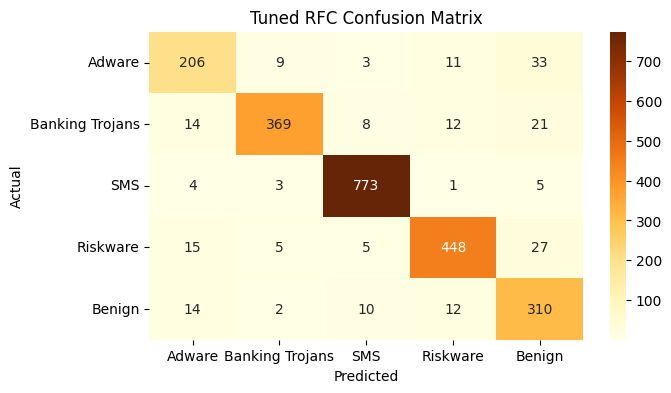

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train & test splits based on filtered set
X_train = red_fsyscalls_train.drop('Class', axis=1)
y_train = red_fsyscalls_train['Class']
X_test = red_fsyscalls_test.drop('Class', axis=1)
y_test = red_fsyscalls_test['Class']

# Parameter grid
param_grid = {
    'n_estimators': [2, 4, 6, 7, 8, 12, 15, 30, 40]
    # 'max_depth': [2, 4, 5, 6, 7, 8, 10],
    # 'class_weight': [None, "balanced", "balanced_subsample"]
}

# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator
best_rfc = grid_search.best_estimator_

# Make predictions with the best estimator
predictions = best_rfc.predict(X_test)

# Add classification_report to clReports
cr_RFC_tuned = classification_report(y_test, predictions)
clReports['RFC_top30_tuned'] = cr_RFC_tuned
# Print the best parameters and the evaluation
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:\n", cr_RFC_tuned)
print("Accuracy:", accuracy_score(y_test, predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

class_labels = ['Adware', 'Banking Trojans', 'SMS', 'Riskware', 'Benign']
plt.figure(figsize=(7, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrBr', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Tuned RFC Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# # Visualize all the Classification reports to determine the best model
# import matplotlib.pyplot as plt
# import seaborn as sns

# malware_classes = ['Adware', 'Banking Trojans', 'SMS', 'Riskware', 'Benign']
# # dictionaries to store metrics data for each class and model
# metrics_data = {
#     'Model': [],
#     'Malware Class': [],
#     'Accuracy': [],
#     'Precision': [],
#     'Recall': [],
#     'F1 Score': []
# }

# # Extract data
# for model_name, report in clReports.items():
#     for malware_class in malware_classes:
#         if malware_class in report['class']:
#             # Extract each metric
#             metrics_data['Model'].append(model_name)
#             metrics_data['Malware Class'].append(malware_class)
#             metrics_data['Accuracy'].append(report[malware_class]['accuracy'])
#             metrics_data['Precision'].append(report[malware_class]['precision'])
#             metrics_data['Recall'].append(report[malware_class]['recall'])
#             metrics_data['F1 Score'].append(report[malware_class]['f1-score'])

# import pandas as pd

# # Convert the metrics data into a DataFrame
# df_metrics = pd.DataFrame(metrics_data)

# # List of metrics for plotting
# metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))  # Adjust the layout and size as needed
# axes = axes.flatten()

# for i, metric in enumerate(metric_names):
#     sns.barplot(x='Malware Class', y=metric, hue='Model', data=df_metrics, ax=axes[i])
#     axes[i].set_title(f'Comparison of Model {metric} by Malware Class')
#     axes[i].set_ylabel(metric)
#     axes[i].set_xlabel('Malware Class')
#     axes[i].legend(title='Model')
#     axes[i].tick_params(axis='x', rotation=45)

# plt.tight_layout()
# plt.show()


In [58]:
print(clReports)

{'RFC_allfeatures': '              precision    recall  f1-score   support\n\n           1       0.88      0.94      0.91       262\n           2       0.98      0.89      0.93       424\n           3       0.97      0.99      0.98       786\n           4       0.94      0.92      0.93       500\n           5       0.89      0.94      0.91       348\n\n    accuracy                           0.94      2320\n   macro avg       0.93      0.93      0.93      2320\nweighted avg       0.94      0.94      0.94      2320\n', 'RFC_allfeatures_tuned': '              precision    recall  f1-score   support\n\n           1       0.87      0.95      0.91       262\n           2       0.97      0.89      0.93       424\n           3       0.98      0.99      0.98       786\n           4       0.96      0.93      0.94       500\n           5       0.90      0.95      0.92       348\n\n    accuracy                           0.95      2320\n   macro avg       0.94      0.94      0.94      2320\nweighte